<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

fatal: destination path 'autoencoders_census' already exists and is not an empty directory.
/content/autoencoders_census


In [2]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import DataTransformer
from data_loader import DataLoader
from autoencoder import AutoencoderModel

importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [6]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [7]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [8]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, variable_types = data_loader.prepare_original_dataset(original_df)



In [9]:
original_df.shape

(14765, 305)

In [10]:
project_data.shape

(14765, 108)

# Transforming the original data set

In [66]:
# Data Transformation
data_transformer = DataTransformer(variable_types)
transformed_df = data_transformer.transform_dataframe(project_data)

# If we want to add indicators for missing values, but we need to also add the appropriate variable types for the missing
# project_data_missing = data_transformer.add_missing_indicators(project_data)
# transformed_df = data_transformer.transform_dataframe(project_data_missing)


In [67]:
transformed_df.shape

(14765, 666)

In [72]:
# This does not work. Need to figure out why.
# data_transformer.reverse_transform_dataframe(transformed_df)

ValueError: ignored

# Autoencoder training

## Hyperparameter search and model training

The training of an autoencoder model while effectively handling missing data with mask variables.

In [51]:


# Instantiate the class
model = AutoencoderModel()

# Preprocess the data
X_train, X_test = model.preprocess_dataset(transformed_df)

# Define the tuner
tuner = model.define_tuner()

# Perform hyperparameter search
tuner.search(X_train, X_train, epochs=model.EPOCHS, batch_size=model.BATCH_SIZE, validation_data=(X_test, X_test))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=model.NUM_TRIALS)[0]
final_model = model.build_autoencoder(best_hps)




Trial 10 Complete [00h 00m 55s]
val_loss: 0.05208473652601242

Best val_loss So Far: 0.05169451733430227
Total elapsed time: 00h 09m 43s


In [ ]:
best_hps.__dict__

In [53]:
# Train the final model
history = final_model.fit(X_train, X_train,
                           epochs=30,
                           batch_size=model.BATCH_SIZE,
                           verbose=1,
                           validation_data=(X_test, X_test))

Epoch 1/30
370/370 [==============================] - 4s 4ms/step - loss: 0.0683 - val_loss: 0.0593
Epoch 2/30
370/370 [==============================] - 1s 4ms/step - loss: 0.0574 - val_loss: 0.0557
Epoch 3/30
370/370 [==============================] - 1s 4ms/step - loss: 0.0554 - val_loss: 0.0545
Epoch 4/30
370/370 [==============================] - 1s 4ms/step - loss: 0.0544 - val_loss: 0.0538
Epoch 5/30
370/370 [==============================] - 1s 4ms/step - loss: 0.0537 - val_loss: 0.0531
Epoch 6/30
370/370 [==============================] - 2s 4ms/step - loss: 0.0530 - val_loss: 0.0526
Epoch 7/30
370/370 [==============================] - 2s 4ms/step - loss: 0.0523 - val_loss: 0.0519
Epoch 8/30
370/370 [==============================] - 1s 4ms/step - loss: 0.0517 - val_loss: 0.0513
Epoch 9/30
370/370 [==============================] - 1s 4ms/step - loss: 0.0511 - val_loss: 0.0510
Epoch 10/30
370/370 [==============================] - 1s 4ms/step - loss: 0.0508 - val_loss: 0.0507

Visualize the training and validation loss values over epochs.

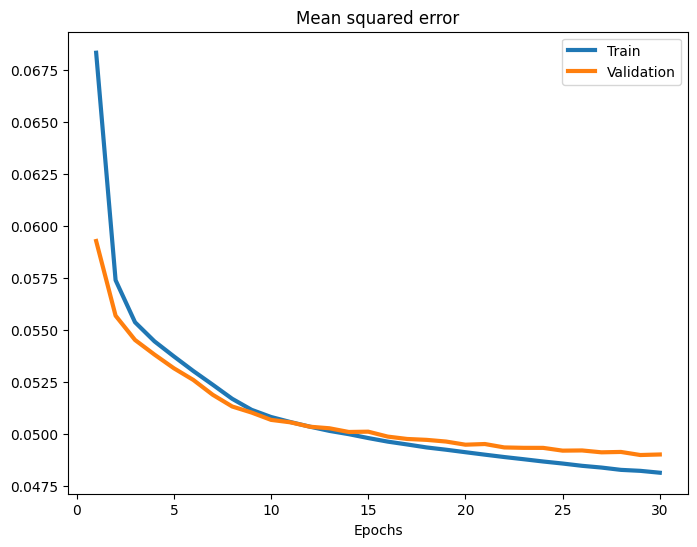

Training MSE = 0.21936067423003364
Validation MSE = 0.2213504968600775


In [54]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Mean squared error")
    sns.lineplot(x=epochs, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=epochs, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")

model_analysis(history.history['loss'], history.history['val_loss'])

In [55]:
# Save the model as a .h5 file
model_filename = "Hyperparameter.h5"
final_model.save(model_filename)

# Store the hyperparameters and evaluation metrics in a dictionary
hyperparameters_dict = {"learning_rate": best_hps.get('learning_rate'),
                        "batch_size": best_hps.get('batch_size'),
                        "num_epochs": 10,
                        "loss": history.history['loss'][-1],
                        "val_loss": history.history['val_loss'][-1]}

## Making Predictions and Filling in the Missing Values


In [56]:
import numpy as np

# Fill the missing values with some initial guess. Here, the median of each column is used.
filled = transformed_df.fillna(transformed_df.median())

# Define a condition for stopping the iteration
epsilon = 1e-5
old_filled = None

while old_filled is None or np.abs(filled - old_filled).mean().mean() > epsilon:
  # Save the old filled DataFrame for convergence check
  old_filled = filled.copy()

  # Run the data through the autoencoder, which will return a complete version of the data.
  predicted = final_model.predict(filled)

  # Replace the initially guessed values in the original data with the corresponding values from the autoencoder's output. But keep the observed values unchanged.
  mask = transformed_df.isna()
  filled[mask] = np.where(mask, predicted, filled)


462/462 [==============================] - 1s 1ms/step


In [71]:
filled

,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
0,0.508875,0.410450,0.234082,0.093095,0.502094,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.347927,0.224818,0.150313,0.058070,0.407674,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.142144,0.200125,0.124225,0.071188,0.381809,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.161873,0.475908,0.270584,0.101754,0.613298,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.415955,0.265058,0.147445,0.062642,0.364084,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,0.018136,0.128760,0.069489,0.040590,0.076937,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14761,0.030378,0.311711,0.173037,0.060075,0.281688,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14762,0.021987,0.377164,0.215114,0.076975,0.372255,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14763,0.087971,0.577465,0.188926,0.082226,0.089027,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [68]:
transformed_df.shape

(14765, 666)

In [69]:
filled.shape

(14765, 666)

In [73]:
# data_transformer.reverse_transform_dataframe(filled)


In [ ]:



# Repeat steps 2 and 3 for a number of times or until the changes in the imputed values become small enough.

## Examine Training Output Statistics

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

In [74]:
final_model.predict(filled)[0,:]

462/462 [==============================] - 1s 2ms/step


array([ 1.89122915e-01,  4.10447568e-01,  2.34079778e-01,  9.30947065e-02,
        5.02087831e-01,  2.78602540e-02, -4.21598786e-03,  2.91446559e-02,
        2.44931191e-01,  2.98616290e-01,  2.40152761e-01,  1.45682365e-01,
        6.17845096e-02,  1.57900766e-01,  8.01172435e-01,  9.32659432e-02,
        3.50093096e-01,  2.49791667e-01,  1.85082018e-01,  1.77001283e-01,
        7.65709355e-02,  5.34655713e-02,  2.40654886e-01,  4.61146653e-01,
        1.52413011e-01,  1.16182089e-01,  1.94526985e-02, -5.75297326e-03,
        2.42295519e-01,  4.58722949e-01,  1.01968087e-02,  2.95380317e-02,
        1.66922763e-01,  1.16700411e-01,  5.36480308e-01,  1.79867119e-01,
        3.11462045e-01,  6.04657888e-01,  1.01977222e-01,  3.08855295e-01,
        4.21264209e-02, -8.54005665e-03,  9.85647321e-01,  2.54641846e-02,
       -1.76016800e-02,  8.28970611e-01,  2.49952637e-02,  4.90036458e-02,
        2.61444002e-02,  1.02412738e-01,  3.82391363e-02, -6.28488511e-03,
        9.86377358e-01,  

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

462/462 [==============================] - 1s 2ms/step


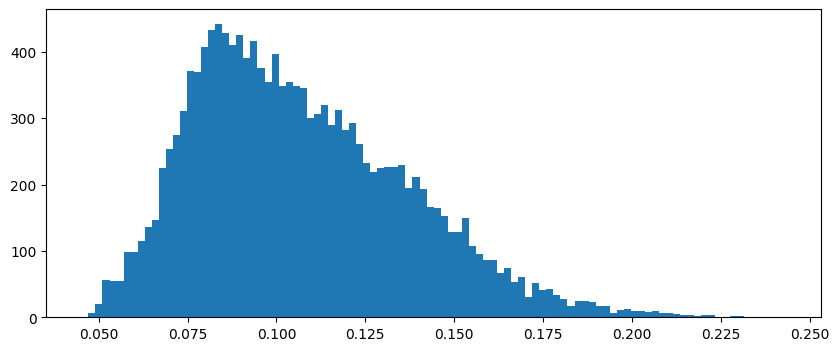

In [75]:
plt.figure(figsize=(10, 4))
# reconstruct the original data
normal_reconstructions = final_model.predict(filled)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions,filled)
plt.hist(normal_loss, bins=100)
plt.show()

The threshold value based on the mean and standard deviation of the reconstruction error. This threshold provides a reference point for distinguishing between normal reconstruction errors and potential outliers.

In [76]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

0.16696367144928329


Visualize the distribution of the reconstruction errors and highlight the threshold for identifying outliers in the reconstruction error.

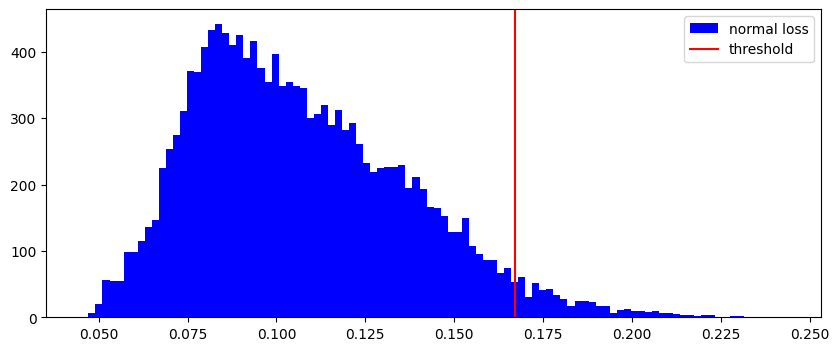

In [77]:
plt.figure(figsize=(10, 4))
plt.hist(normal_loss, bins=100, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

In [78]:
normal_loss

<tf.Tensor: shape=(14765,), dtype=float64, numpy=
array([0.14623899, 0.12531042, 0.17166144, ..., 0.13658244, 0.0918571 ,
       0.1362742 ])>

In [79]:
reconstructed_error_df = pd.DataFrame()
reconstructed_error_df['Reconstructed_Error'] = normal_loss
reconstructed_error_df.to_csv('data_with_reconstructed_errors.csv', index=False)
reconstructed_error_df.head()

,Reconstructed_Error
0,0.146239
1,0.125310
2,0.171661
3,0.179502
4,0.113352


Obtain the indices in descending order of the reconstruction errors.

In [80]:
sorted_indices = np.argsort(normal_loss)[::-1]

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [81]:

k = 100  # Number of samples to select
samples_with_high_error = transformed_df.iloc[sorted_indices[:k]]
samples_with_high_error.head()

,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
1743,0.065919,0.605634,0.398231,0.129180,0.965690,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7247,0.153676,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
147,0.245111,0.352113,0.197642,0.102597,0.903571,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6455,0.287644,0.647887,0.450590,0.136637,0.960988,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7757,0.158000,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [82]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = transformed_df.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
2,0.142144,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.161873,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.356232,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12,0.211872,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
15,0.043351,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
anomaly_tuples.shape

(511, 774)

Reconstruct the transformed data using the trained autoencoder model and get the combined dataframe of the original transformed data with its reconstructed version.

In [84]:

reconstructed_data = final_model.predict(filled)

reconstructed_df = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)

combined_df = pd.concat([transformed_df, reconstructed_df], axis=1)
combined_df.head()

462/462 [==============================] - 1s 2ms/step


,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
0,0.508875,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.094699,0.010258,0.478763,0.502640,0.036996,-0.004574,0.049550,0.712292,0.251197,0.015701
1,0.347927,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.083328,0.021648,0.144092,0.779924,0.048377,0.012959,0.066201,0.681650,0.206288,0.026056
2,0.142144,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.137594,0.021234,0.098793,0.880064,0.051081,-0.000071,0.059779,0.740601,0.208614,0.034818
3,0.161873,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.131346,-0.005272,0.520335,0.476695,0.003758,-0.004551,0.005212,0.743296,0.244017,-0.002144
4,0.415955,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.058600,0.683432,0.216119,0.105962,0.673470,0.036102,0.032488,0.272748,0.094091,0.616959


In [ ]:
reconstructed_data1 = final_model.predict(transformed_df)
reconstructed_df1 = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)
columns_to_modify = ["weight","stheight","stweight","bmi","bmipct"]
transformed_df[columns_to_modify] = transformed_df[columns_to_modify].replace(0, np.nan)

reconstructed_df1.head()

462/462 [==============================] - 1s 2ms/step


,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,0.243521,0.487967,0.257393,0.092425,0.566172,0.001605,0.014359,0.008653,0.005616,0.022474,...,0.073574,-0.011989,0.622469,0.395902,-0.010063,0.034001,0.022694,0.822259,0.145681,-0.008314
1,0.240623,0.458117,0.223996,0.089072,0.542006,0.000386,0.004247,0.003312,0.004379,0.012389,...,0.072677,0.029253,0.692635,0.261063,0.045464,0.003265,0.020947,0.811055,0.128486,0.037601
2,0.250088,0.495230,0.270631,0.091660,0.568362,0.002327,0.017022,0.012719,0.011244,0.020699,...,0.072180,-0.015729,0.558282,0.454608,-0.014722,0.057626,0.022999,0.788158,0.159457,-0.006930
3,0.254123,0.499693,0.278764,0.091191,0.569709,0.002771,0.018657,0.015218,0.014702,0.019608,...,0.071324,-0.018027,0.518842,0.490680,-0.017585,0.072142,0.023186,0.767204,0.167921,-0.006080
4,0.206245,0.487219,0.222384,0.091701,0.565774,-0.000235,0.004138,0.005335,0.011341,0.039120,...,0.030209,0.769667,0.249821,0.046002,0.765051,-0.008666,0.009436,0.252173,0.025400,0.738532


Calculate the cost standardization and map reconstructed binary values to categories.

\#1 approach for getting cost values:

In [ ]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

cost = {}
mapped_categories = {}

for column in transformed_df[categorical_vars]:
  probability = transformed_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost[column] = cost_value

for column, cost in cost.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories[column] = (reconstructed_df[column] > cost).astype(int)

<ipython-input-52-9a1a964cdb25>:9: RuntimeWarning: divide by zero encountered in double_scalars
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)


In [ ]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

cost1 = {}
mapped_categories1 = {}

for column in transformed_df[categorical_vars]:
  probability = transformed_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost1[column] = cost_value

for column, cost in cost1.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories1[column] = (reconstructed_df1[column] > cost).astype(int)

<ipython-input-53-fafba6672185>:9: RuntimeWarning: divide by zero encountered in double_scalars
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)


Evaluate the performance of the reconstructed categories compared to the original dataset. A higher AUC score indicates better performance in distinguishing different instances.

In [ ]:
auc_scores = {}

for column in mapped_categories:

    mapped_values = mapped_categories[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


{'weight_missing': nan,
 'age_missing': 0.5,
 'sex_missing': 0.5,
 'grade_missing': 0.5,
 'Hispanic or Latino_missing': 0.5,
 'race_missing': 0.5,
 'stheight_missing': 0.5271925870400059,
 'stweight_missing': 0.52766267228119,
 'bmi_missing': 0.5274727884782676,
 'bmipct_missing': 0.5277143793084687,
 'obese_missing': 0.5277098217604033,
 'overweight_missing': 0.527548569131943,
 'sexual identity_missing': 0.6944105679215653,
 'sex/sexual contacts_missing': 0.7090584454966584,
 'sexid_missing': 0.69623482946731,
 'sexid2_missing': 0.6924669833366347,
 'sexpart_missing': 0.6727990947360163,
 'sexpart2_missing': 0.6602887355977122,
 'seat belt use_missing': 0.9083013169468163,
 'riding with a drinking driver_missing': 0.5,
 'drinking and driving_missing': 0.5142445738774981,
 'texting and driving_missing': 0.5046123689991503,
 'weapon carrying_missing': 0.9393910955205614,
 'weapon carrying at school_missing': 0.5,
 'gun carrying past 12 mos_missing': 0.8620366078987536,
 'safety concern

In [ ]:
from sklearn.metrics import confusion_matrix

num_categories = len(categorical_vars)
confusion_matrices = {}

for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = mapped_categories[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for weight_missing:
[[14765]]

Confusion Matrix for age_missing:
[[14684     0]
 [   81     0]]

Confusion Matrix for sex_missing:
[[14638     0]
 [  127     0]]

Confusion Matrix for grade_missing:
[[14621     0]
 [  144     0]]

Confusion Matrix for Hispanic or Latino_missing:
[[14428     0]
 [  337     0]]

Confusion Matrix for race_missing:
[[14428     0]
 [  337     0]]

Confusion Matrix for stheight_missing:
[[ 2006 11140]
 [  159  1460]]

Confusion Matrix for stweight_missing:
[[ 1994 11152]
 [  156  1463]]

Confusion Matrix for bmi_missing:
[[ 2064 11142]
 [  158  1401]]

Confusion Matrix for bmipct_missing:
[[ 1971 11175]
 [  153  1466]]

Confusion Matrix for obese_missing:
[[ 1979 11167]
 [  154  1465]]

Confusion Matrix for overweight_missing:
[[ 1991 11155]
 [  156  1463]]

Confusion Matrix for sexual identity_missing:
[[13538   570]
 [  375   282]]

Confusion Matrix for sex/sexual contacts_missing:
[[4992 6405]
 [  67 3301]]

Confusion Matrix for sexid_mis

In [ ]:
merged_df = (pd.DataFrame(mapped_categories)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df.head(10)

,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,race_missing,stheight_missing,stweight_missing,bmi_missing,bmipct_missing,...,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan,weight,stheight,stweight,bmi,bmipct
0,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.243521,0.487967,0.257393,0.092425,0.566172
1,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,1,0.240623,0.458117,0.223996,0.089072,0.542006
2,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.250088,0.495230,0.270631,0.091660,0.568362
3,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.254123,0.499693,0.278764,0.091191,0.569709
4,0,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0.206245,0.487219,0.222384,0.091701,0.565774
5,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.244041,0.488543,0.258442,0.092364,0.566346
6,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.250461,0.495644,0.271384,0.091617,0.568487
7,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.249093,0.494131,0.268627,0.091776,0.568031
8,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.240214,0.466383,0.232188,0.090327,0.549461
9,0,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0.204632,0.483778,0.221751,0.090718,0.561330


In [ ]:
merged_df1 = (pd.DataFrame(mapped_categories1)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df1.head(10)

,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,race_missing,stheight_missing,stweight_missing,bmi_missing,bmipct_missing,...,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan,weight,stheight,stweight,bmi,bmipct
0,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.243521,0.487967,0.257393,0.092425,0.566172
1,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,1,0.240623,0.458117,0.223996,0.089072,0.542006
2,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.250088,0.495230,0.270631,0.091660,0.568362
3,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.254123,0.499693,0.278764,0.091191,0.569709
4,0,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0.206245,0.487219,0.222384,0.091701,0.565774
5,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.244041,0.488543,0.258442,0.092364,0.566346
6,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.250461,0.495644,0.271384,0.091617,0.568487
7,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.249093,0.494131,0.268627,0.091776,0.568031
8,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0.240214,0.466383,0.232188,0.090327,0.549461
9,0,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0.204632,0.483778,0.221751,0.090718,0.561330


\#2 approach for getting cost values:

In [ ]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

mapped_categories_z_score = {}

cost_df = pd.DataFrame()

for column in transformed_df[categorical_vars]:
    probability = transformed_df[column].mean(axis=0)
    std = transformed_df[column].std(axis=0)

    cost_values = []

    for index, value in transformed_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df[column] = cost_values

    cost_df.head()

for column, cost in cost_df.items():
    lower_bound = transformed_df[column].mean(axis=0) - cost
    upper_bound = transformed_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
    mapped_categories_z_score[column] = mapped_values

In [ ]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

mapped_categories2 = {}

cost_df2 = pd.DataFrame()

for column in transformed_df[categorical_vars]:
    probability = transformed_df[column].mean(axis=0)
    std = transformed_df[column].std(axis=0)

    cost_values = []

    for index, value in transformed_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df2[column] = cost_values

    cost_df2.head()

for column, cost in cost_df2.items():
    lower_bound = transformed_df[column].mean(axis=0) - cost
    upper_bound = transformed_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df1[column] > lower_bound) & (reconstructed_df1[column] < upper_bound)).astype(int)
    mapped_categories2[column] = mapped_values

In [ ]:
mapped_values_df = pd.DataFrame(mapped_categories2)
true_labels_df = transformed_df[categorical_vars]
fpr, tpr, _ = roc_curve(true_labels_df.values.flatten(), mapped_values_df.values.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9986846688726954

In [ ]:
predicted_labels = mapped_values_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

array([[9649345,   14765],
       [   1864, 1688311]])

In [ ]:
numeric_vars = ["weight", "stheight", "stweight", "bmi", "bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

best_auc_score = None
best_std_multiplier = None
best_mapped_categories = None

for std_multiplier in np.arange(0.5, 7.1, 0.1):  # Try different values of std_multiplier from 1.0 to 7.0
    cost_df = pd.DataFrame()

    for column in transformed_df[categorical_vars]:
        probability = transformed_df[column].mean(axis=0)
        std = transformed_df[column].std(axis=0)

        cost_values = []
        for index, value in transformed_df[column].items():
            cost_value = (value - probability) / (std_multiplier * std) if std != 0 else np.inf
            cost_values.append(cost_value)

        cost_df[column] = cost_values

    # Apply the cost_df to the reconstructed_df to calculate mapped_values
    mapped_categories = {}
    for column, cost in cost_df.items():
        lower_bound = transformed_df[column].mean(axis=0) - cost
        upper_bound = transformed_df[column].mean(axis=0) + cost
        mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
        mapped_categories[column] = mapped_values

    # Calculate the AUC score for the whole DataFrame
    mapped_values_df = pd.DataFrame(mapped_categories)
    true_labels_df = transformed_df[categorical_vars]
    fpr, tpr, _ = roc_curve(true_labels_df.values.flatten(), mapped_values_df.values.flatten())
    roc_auc = auc(fpr, tpr)

    # Check if the current AUC score is better than the previous best AUC score
    if best_auc_score is None or roc_auc > best_auc_score:
        best_auc_score = roc_auc
        best_std_multiplier = std_multiplier
        best_mapped_categories = mapped_categories


In [ ]:
print("Best std multiplier:", best_std_multiplier)
print("Best AUC score:", best_auc_score)

Best std multiplier: 0.5
Best AUC score: 0.9992360910627053


In [ ]:
auc_scores = {}

for column in mapped_categories2:

    mapped_values = mapped_categories2[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


{'weight_missing': nan,
 'age_missing': 1.0,
 'sex_missing': 1.0,
 'grade_missing': 1.0,
 'Hispanic or Latino_missing': 1.0,
 'race_missing': 1.0,
 'stheight_missing': 1.0,
 'stweight_missing': 1.0,
 'bmi_missing': 1.0,
 'bmipct_missing': 1.0,
 'obese_missing': 1.0,
 'overweight_missing': 1.0,
 'sexual identity_missing': 1.0,
 'sex/sexual contacts_missing': 1.0,
 'sexid_missing': 1.0,
 'sexid2_missing': 1.0,
 'sexpart_missing': 1.0,
 'sexpart2_missing': 1.0,
 'seat belt use_missing': 1.0,
 'riding with a drinking driver_missing': 1.0,
 'drinking and driving_missing': 1.0,
 'texting and driving_missing': 1.0,
 'weapon carrying_missing': 1.0,
 'weapon carrying at school_missing': 1.0,
 'gun carrying past 12 mos_missing': 1.0,
 'safety concerns at school_missing': 1.0,
 'threatened at school_missing': 1.0,
 'physical fighting_missing': 1.0,
 'physical fighting at school_missing': 1.0,
 'forced sexual intercourse_missing': 1.0,
 'sexual violence_missing': 1.0,
 'sexual dating violence_miss

In [ ]:
num_categories = len(categorical_vars)
confusion_matrices = {}

for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = mapped_categories2[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for weight_missing:
[[    0 14765]
 [    0     0]]

Confusion Matrix for age_missing:
[[14684     0]
 [    0    81]]

Confusion Matrix for sex_missing:
[[14638     0]
 [    0   127]]

Confusion Matrix for grade_missing:
[[14621     0]
 [    0   144]]

Confusion Matrix for Hispanic or Latino_missing:
[[14428     0]
 [    0   337]]

Confusion Matrix for race_missing:
[[14428     0]
 [    0   337]]

Confusion Matrix for stheight_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for stweight_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for bmi_missing:
[[13206     0]
 [    0  1559]]

Confusion Matrix for bmipct_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for obese_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for overweight_missing:
[[13146     0]
 [    0  1619]]

Confusion Matrix for sexual identity_missing:
[[14108     0]
 [    0   657]]

Confusion Matrix for sex/sexual contacts_missing:
[[11397     0]
 [    0  3368]]

Confu

In [ ]:
merged_df1 = (reconstructed_df[numeric_vars]).merge((pd.DataFrame(mapped_categories2)), left_index = True, right_index = True)
merged_df1.head(10)

,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,0.243521,0.487967,0.257393,0.092425,0.566172,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
1,0.240623,0.458117,0.223996,0.089072,0.542006,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
2,0.250088,0.495230,0.270631,0.091660,0.568362,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
3,0.254123,0.499693,0.278764,0.091191,0.569709,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
4,0.206245,0.487219,0.222384,0.091701,0.565774,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1
5,0.244041,0.488543,0.258442,0.092364,0.566346,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
6,0.250461,0.495644,0.271384,0.091617,0.568487,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
7,0.249093,0.494131,0.268627,0.091776,0.568031,1,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
8,0.240214,0.466383,0.232188,0.090327,0.549461,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
9,0.204632,0.483778,0.221751,0.090718,0.561330,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1


In [ ]:
reconstructed_original_format = pd.DataFrame(mapped_categories2)
reconstructed_original_format.head()

,weight_missing,age_missing,sex_missing,grade_missing,Hispanic or Latino_missing,race_missing,stheight_missing,stweight_missing,bmi_missing,bmipct_missing,...,sunburn_5 or more times,sunburn_nan,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1


**#3**

In [ ]:
import re

column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = re.match(r'(.+)_', column).group(1)
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

normalized_df = categorical_df.copy()

for group in column_groups.values():
    column_sum = categorical_df[group].sum(axis=0)
    normalized_values = column_sum / column_sum.sum()
    normalized_df[group] = categorical_df[group] / normalized_values

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

In [ ]:
predicted_df

,weight_missing,age_missing,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,age_17 years old,age_18 years old or older,age_nan,...,difficulty concentrating_missing,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_missing,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
14761,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14762,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14763,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
predicted_labels = predicted_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

array([[8321962, 1342148],
       [1437703,  252472]])

In [ ]:
for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = predicted_df[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for weight_missing:
[[    0 14765]
 [    0     0]]

Confusion Matrix for age_missing:
[[14684     0]
 [   81     0]]

Confusion Matrix for sex_missing:
[[9781 4857]
 [  68   59]]

Confusion Matrix for grade_missing:
[[12899  1722]
 [  101    43]]

Confusion Matrix for Hispanic or Latino_missing:
[[13846   582]
 [  321    16]]

Confusion Matrix for race_missing:
[[13945   483]
 [  321    16]]

Confusion Matrix for stheight_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for stweight_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for bmi_missing:
[[    0 13206]
 [    0  1559]]

Confusion Matrix for bmipct_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for obese_missing:
[[10047  3099]
 [ 1145   474]]

Confusion Matrix for overweight_missing:
[[9623 3523]
 [1182  437]]

Confusion Matrix for sexual identity_missing:
[[13611   497]
 [  644    13]]

Confusion Matrix for sex/sexual contacts_missing:
[[11219   178]
 [  629  2739]]

Confusion Mat

In [ ]:
column_sums = reconstructed_df1.sum(axis=0)
scaling_factor = 1 / column_sums.sum()
normalized_df1 = reconstructed_df1 * scaling_factor

In [ ]:
column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = re.match(r'(.+)_', column).group(1)
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df1 [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

In [ ]:
predicted_df

,weight_missing,age_missing,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,age_17 years old,age_18 years old or older,age_nan,...,difficulty concentrating_missing,difficulty concentrating_No,difficulty concentrating_Yes,difficulty concentrating_nan,how well speak English_missing,how well speak English_Not at all,how well speak English_Not well,how well speak English_Very well,how well speak English_Well,how well speak English_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14761,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14762,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14763,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
predicted_labels = predicted_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

array([[8370013, 1294097],
       [1389652,  300523]])

In [ ]:
for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = predicted_df[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for weight_missing:
[[    0 14765]
 [    0     0]]

Confusion Matrix for age_missing:
[[14684     0]
 [   81     0]]

Confusion Matrix for sex_missing:
[[14638     0]
 [  127     0]]

Confusion Matrix for grade_missing:
[[14621     0]
 [  144     0]]

Confusion Matrix for Hispanic or Latino_missing:
[[14428     0]
 [  337     0]]

Confusion Matrix for race_missing:
[[14428     0]
 [  337     0]]

Confusion Matrix for stheight_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for stweight_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for bmi_missing:
[[    0 13206]
 [    0  1559]]

Confusion Matrix for bmipct_missing:
[[    0 13146]
 [    0  1619]]

Confusion Matrix for obese_missing:
[[13146     0]
 [ 1619     0]]

Confusion Matrix for overweight_missing:
[[13146     0]
 [ 1619     0]]

Confusion Matrix for sexual identity_missing:
[[14108     0]
 [  657     0]]

Confusion Matrix for sex/sexual contacts_missing:
[[11292   105]
 [  656  2712]]

Confu